In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Subset
from tqdm import tqdm

transform = transforms.Compose([
    transforms.ToTensor(),           # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

mnist_train = MNIST(root='./data', train=True, transform=transform, download=True)

# If trained with only one pattern (ie. same digit), the output will also be this pattern.
# mnist_train = Subset(mnist_train, torch.where(mnist_train.targets == 9)[0])

train_loader = DataLoader(
    mnist_train,
    batch_size=64,
    shuffle=True
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Train loader={len(train_loader)} examples, Device={device}")

Train loader=938 examples, Device=cuda


In [2]:
T = 1000  # total timesteps
betas = torch.linspace(1e-4, 0.02, T)  # example linear schedule
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)

In [3]:
# UNet with additional time and condition inputs.
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is BCHW
        diffY = x2.size()[-1] - x1.size()[-1]
        diffX = x1.size()[-2] - x1.size()[-2]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class EmbeddedFC(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Linear(out_dim, out_dim)
        )
    
    def forward(self, t):
        t_embed = self.fc(t)
        return t_embed

# copied from https://github.com/lllyasviel/ControlNet/blob/main/ldm/modules/attention.py#L79
def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module
    
class UNet(nn.Module):
    def __init__(self, n_channels=3):
        super().__init__()
        self.n_channels = n_channels
        
        self.inc = (DoubleConv(n_channels, 64))
        # ==== Control Net Zero Conv ====
        self.add_module("zero_conv", zero_module(nn.Conv2d(n_channels, 64, kernel_size=3, padding=1, bias=False)))
        # ===============================
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        
        self.up1 = (Up(256, 128))
        self.up2 = (Up(128, 64))
        self.outc = nn.Sequential(
            nn.Conv2d(64, n_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
        
        self.t_embed1 = EmbeddedFC(1, 256)
        self.t_embed2 = EmbeddedFC(1, 128)

        # shift the guassian mean away from 0 where relu does not have a smooth gradient.
        self.shift_mu = -0.05
        self.shift_variance = 0.1
        
    def forward(self, x, t, c, enable_guide:bool=False):
        # x=[B,n_channel,H,W]
        # t=[B,1]
        # c=None in the 1st round of train (same as stable diffusion trained without control)
        # c=[B,1,H,W] in the 2nd round of finetuning (c = the top half raw image; bottom half masked)
        
        x1 = self.inc(x) # out=[B, 64, H, W]
        
        # ==== Control Net Zero Conv ====
        if enable_guide:
            x1 = x1 + self.zero_conv(c) # out=[B, 64, H, W]
        # ===============================
        
        x2 = self.down1(x1) # out=[B, 128, H/2, W/2]
        x3 = self.down2(x2) # out=[B, 256, H/4, W/4]
        
        t1 = self.t_embed1(t) # out=[B, 256]
        t1 = t1.view(-1, 256, 1, 1).expand(-1, 256, x3.shape[-2], x3.shape[-1]) # out=[B, 256, H/4, W/4]
        x = self.up1(x3 + t1, x2) # out=[B, 128, H/2, W/2]

        t2 = self.t_embed2(t) # out=[B, 128]
        t2 = t2.view(-1, 128, 1, 1).expand(-1, 128, x.shape[-2], x.shape[-1]) # out=[B, 128, H/2, W/2]
        x = self.up2(x + t2, x1) # out=[B, 64, H, W]
        
        logits = self.outc(x) # out=[B, n_channel, H, W]
        logits = logits * self.shift_variance + self.shift_mu
        return logits


In [4]:
import torch.optim as optim

model = UNet(n_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

In [5]:
def train(enable_guide, num_epochs = 7):
    for epoch in range(num_epochs):
        running_loss = 0
        for batch_idx, (x0, _) in enumerate(train_loader):
            x0 = x0.to(device)  # shape [B, 1, 28, 28]
            c = x0.clone()  # shape [B, 1, 28, 28]
            c[:, :, 28//2:, :] = -1.0
            
            # Sample random timestep for each image in the batch
            t = torch.randint(0, T, (x0.size(0),), device=device).long()
    
            # Compute corresponding alpha cumulative product for each t
            alpha_bar_t = alphas_cumprod[t].to(device).view(-1, 1, 1, 1)
    
            # Sample noise
            noise = torch.randn_like(x0)
    
            # Create noisy image x_t
            x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise
    
            # Predict noise using model
            # Normalize timestep to a range or use embedding directly
            t_normalized = t.unsqueeze(-1).float() / T
    
            pred_noise = model(x_t, t_normalized, c, enable_guide)
            
            # Compute loss
            loss = mse_loss(pred_noise, noise)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
    
        print(f"Memory={torch.cuda.memory_allocated() / 1024 ** 3:.2f} GB")
        print(f"Epoch {epoch}: Loss {running_loss}")

In [6]:
# first round just train without guide/controlnet
for name, param in model.named_parameters():
    param.requires_grad = True
  
train(enable_guide=False)

Memory=0.05 GB
Epoch 0: Loss 450.2885784804821
Memory=0.05 GB
Epoch 1: Loss 348.45066034793854
Memory=0.05 GB
Epoch 2: Loss 183.76084625720978
Memory=0.05 GB
Epoch 3: Loss 76.70716424286366
Memory=0.05 GB
Epoch 4: Loss 40.60328019596636
Memory=0.05 GB
Epoch 5: Loss 32.6102561596781
Memory=0.05 GB
Epoch 6: Loss 30.476668110117316


In [7]:
# second round train with guide/controlnet
# freeze/lock the remaining parameters
target_name = "zero_conv.weight"
for name, param in model.named_parameters():
    if name.startswith(target_name):
        param.requires_grad = True
    else:
        param.requires_grad = False
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

train(enable_guide=True)

inc.double_conv.0.weight: requires_grad=False
inc.double_conv.1.weight: requires_grad=False
inc.double_conv.1.bias: requires_grad=False
inc.double_conv.3.weight: requires_grad=False
inc.double_conv.4.weight: requires_grad=False
inc.double_conv.4.bias: requires_grad=False
zero_conv.weight: requires_grad=True
down1.maxpool_conv.1.double_conv.0.weight: requires_grad=False
down1.maxpool_conv.1.double_conv.1.weight: requires_grad=False
down1.maxpool_conv.1.double_conv.1.bias: requires_grad=False
down1.maxpool_conv.1.double_conv.3.weight: requires_grad=False
down1.maxpool_conv.1.double_conv.4.weight: requires_grad=False
down1.maxpool_conv.1.double_conv.4.bias: requires_grad=False
down2.maxpool_conv.1.double_conv.0.weight: requires_grad=False
down2.maxpool_conv.1.double_conv.1.weight: requires_grad=False
down2.maxpool_conv.1.double_conv.1.bias: requires_grad=False
down2.maxpool_conv.1.double_conv.3.weight: requires_grad=False
down2.maxpool_conv.1.double_conv.4.weight: requires_grad=False
down

In [8]:
# randomly sample some data
mnist_test = MNIST(root='./data', train=False, transform=transform, download=True)

hint_loader = DataLoader(
    mnist_test,
    batch_size=16,   # 16 random images
    shuffle=True
)

c, labels = next(iter(hint_loader))
c[:, :, 28//2:, :] = -1.0  # mask lower half

In [9]:
@torch.no_grad()
def sample(model, T, c):
    model.eval()
    shape = c.shape
    x = torch.randn(shape, device=device)  # start from pure noise
    for t in reversed(range(T)):
        # Create tensor for current timestep
        t_tensor = torch.full((shape[0], 1), t, device=device).float() / T
        # Predict noise
        pred_noise = model(x, t_tensor, c, enable_guide=True)
        # Compute coefficients
        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]
        alpha_bar_prev = alphas_cumprod[t - 1]
        beta = betas[t]

        # Predict the previous step x_{t-1}
        # Simplified update for demonstration; actual update may require more careful implementation
        x = (1/torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_bar)) * pred_noise)
        # Optionally add noise if t > 0
        if t > 0:
            noise = torch.randn_like(x)
            sigma = 1.05 * torch.sqrt(beta) * (1. - alpha_bar_prev) /  (1. - alpha_bar)
            x += 0.9 * sigma * noise
    return x

# Generate new samples
samples = sample(model, T, c.to(device)).cpu().numpy()

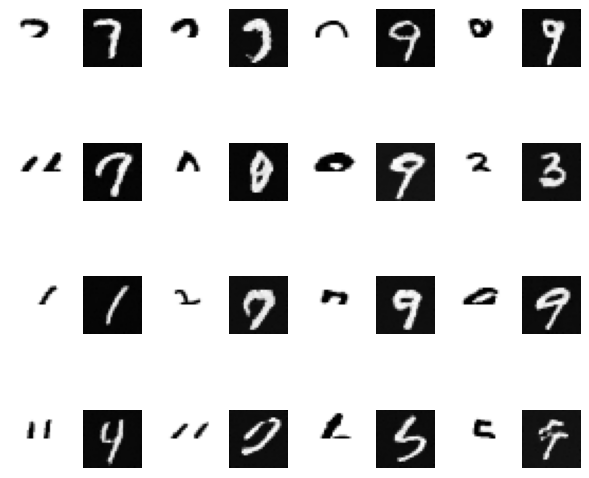

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 8, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    # Each sample is shape [1, 28, 28], so we take the first channel
    img = (1 - c[i//2][0]) if i % 2 ==0 else samples[i//2][0]
    # Rescale the image values from normalization range if needed (e.g., from [-1,1] to [0,1])
    img = (img + 1.) / 2.
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

# For each pair of images, the left is the guide, the right the generated image by DDPM.